In [1]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [2]:
transcript = pd.read_csv('transcripts/transcripts.csv', delimiter='|')
qna =  pd.read_csv('transcripts/QnA.csv', delimiter='|')

# Merge the two dataframes
df = pd.merge(transcript, qna[['transcript','filename']], on='filename')

# rename transcript_x to presentation and transcript_y to QnA
df = df.rename(columns={'transcript_x': 'presentation', 'transcript_y': 'QnA'})

mapping = pd.read_csv('data/mapping.csv')

# create a new column 'AllNames' that concatenates all versions of 'Company' for a 'CompanyName'
mapping['AllNames'] = mapping.groupby('RR_CompanyName')['Transcript_Mapping'].transform(lambda x: ', '.join(x))
mapping.head()

# Load recovery rates
rr = pd.read_csv('data/RR_Bonds.csv')
rr = rr[['Ddate', 'RR', 'CompanyName', 'CUSIP', 'LTDIssuance2', 'Intangibility', 'Receivables1']]

preprocessed_df = pd.read_csv('data/preprocessed_bond_data.csv')

# Add rr columns to preprocessed_df on index
preprocessed_df['RR'] = rr['RR']
preprocessed_df['Ddate'] = rr['Ddate']
preprocessed_df['CompanyName'] = rr['CompanyName']
preprocessed_df['CUSIP'] = rr['CUSIP']
preprocessed_df['LTDIssuance2'] = rr['LTDIssuance2']
preprocessed_df['Intangibility'] = rr['Intangibility']
preprocessed_df['Receivables1'] = rr['Receivables1']

rr = preprocessed_df

# Convert 'Date' column to datetime
rr['Ddate'] = pd.to_datetime(rr['Ddate'], errors='coerce')
rr.head()

# merge rr with mapping on CompanyName and RR_CompanyName
rr = rr.merge(mapping, left_on='CompanyName', right_on='RR_CompanyName')

# join with df on Company and Transcripts_Mapping
merged_df = rr.merge(df, left_on='Transcript_Mapping', right_on='Company')
print(merged_df['CompanyName'].value_counts())

# Ensure the columns are in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Ddate'] = pd.to_datetime(merged_df['Ddate'])

# Compute the difference in days
merged_df['diff'] = (merged_df['Ddate'] - merged_df['Date']).dt.days

merged_df = merged_df[merged_df['Ddate']>merged_df['Date']]
merged_df = merged_df.sort_values(by='Date').groupby(['CUSIP']).tail(1)

print(merged_df['CompanyName'].value_counts())

Ally Financial Inc.               10317
CIT Group Inc.                    10185
Lehman Brothers Holdings, Inc.     2853
Charter Communications, Inc.       2144
Sempra Energy                      1147
                                  ...  
Frontier Group Holdings, Inc.         1
Dayton Superior Corporation           1
Franklin Bank Corp.                   1
Kellwood Company, LLC                 1
Turning Point Brands, Inc.            1
Name: CompanyName, Length: 210, dtype: int64
Lehman Brothers Holdings, Inc.      317
CIT Group Inc.                      291
Charter Communications, Inc.         28
Ford Motor Company                   19
iStar Inc.                           17
                                   ... 
Centrus Energy Corp.                  1
Education Management Corporation      1
Venoco, Inc.                          1
Exelon Corporation                    1
Kellwood Company, LLC                 1
Name: CompanyName, Length: 159, dtype: int64


In [4]:
df = merged_df.copy()

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(df['presentation'].nunique())

# add a number to each transcript based on the 196 unique transcripts
df['transcript_number'] = df['presentation'].factorize()[0]

number_transcript = df[['transcript_number', 'presentation']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

196


,transcript_number,presentation
27094,0,Presentation\nOperator\nGood morning Ladies an...
22380,1,"Presentation\nOperator\nLadies and gentlemen, ..."
5878,2,Presentation\nOperator\nGreetings ladies and g...
6097,3,"Presentation\nOperator\nThank you, all parties..."
6417,4,Presentation\nOperator\nThank you for joining ...


In [5]:
emotion_scores = pd.read_csv('goemotions/emotion_scores_summary.csv')

In [6]:
# merge emotion_scores with number_transcript on transcript_number
emotion_scores = emotion_scores.merge(number_transcript, on='transcript_number')
emotion_scores.head()

,Unnamed: 0,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,transcript_number,presentation
0,0,0.0,0.0,0.0,0.0,0.016939,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.014390,0.0,0.0,0.0,0.0,0,Presentation\nOperator\nGood morning Ladies an...
1,1,0.0,0.0,0.0,0.0,0.128157,0.000000,0.0,0.0,0.0,...,0.0,0.149456,0.0,0.055387,0.0,0.0,0.0,0.0,1,"Presentation\nOperator\nLadies and gentlemen, ..."
2,2,0.0,0.0,0.0,0.0,0.119766,0.027171,0.0,0.0,0.0,...,0.0,0.060978,0.0,0.062132,0.0,0.0,0.0,0.0,2,Presentation\nOperator\nGreetings ladies and g...
3,3,0.0,0.0,0.0,0.0,0.050352,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010958,0.0,0.0,0.0,0.0,3,"Presentation\nOperator\nThank you, all parties..."
4,4,0.0,0.0,0.0,0.0,0.129850,0.000000,0.0,0.0,0.0,...,0.0,0.039329,0.0,0.000000,0.0,0.0,0.0,0.0,4,Presentation\nOperator\nThank you for joining ...


In [7]:
# merge emotion_scores with df on emotion_scores['transcript_number'] == df['transcript_number']
emotion_scores = emotion_scores.merge(df, on='transcript_number')

In [8]:
emotion_scores.head()

,Unnamed: 0,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,Transcript_Mapping,AllNames,filename,presentation_y,Company,Quarter,Year,Date,QnA,diff
0,0,0.0,0.0,0.0,0.0,0.016939,0.000000,0.0,0.0,0.0,...,Kellwood Company,Kellwood Company,"Kellwood Company, Q3 2007 Earnings Call, Dec-0...",Presentation\nOperator\nGood morning Ladies an...,Kellwood Company,Q3,2007.0,2006-12-01,Question and Answer\nOperator\n[Operator Instr...,957
1,1,0.0,0.0,0.0,0.0,0.128157,0.000000,0.0,0.0,0.0,...,Nortel Networks Corp.,Nortel Networks Corp.,"Nortel Networks Corp., Q3 2007 Earnings Call, ...","Presentation\nOperator\nLadies and gentlemen, ...",Nortel Networks Corp.,Q3,2007.0,2007-11-06,Question and Answer\nOperator\n(Operator Instr...,435
2,2,0.0,0.0,0.0,0.0,0.119766,0.027171,0.0,0.0,0.0,...,"Frontier Airlines Holdings, Inc.","Frontier Airlines Holdings, Inc.","Frontier Airlines Holdings, Inc., Q3 2008 Earn...",Presentation\nOperator\nGreetings ladies and g...,"Frontier Airlines Holdings, Inc.",Q3,2008.0,2008-01-25,Question and Answer\nOperator\nThank you. Ladi...,253
3,3,0.0,0.0,0.0,0.0,0.050352,0.000000,0.0,0.0,0.0,...,Tyson Foods Inc.,"Tyson Foods, Inc., Tyson Foods Inc.","Tyson Foods Inc., Q1 2008 Earnings Call, Jan-2...","Presentation\nOperator\nThank you, all parties...",Tyson Foods Inc.,Q1,2008.0,2008-01-28,Question and Answer\nOperator\n[Operator Instr...,69
4,4,0.0,0.0,0.0,0.0,0.129850,0.000000,0.0,0.0,0.0,...,Silgan Holdings Inc.,Silgan Holdings Inc.,"Silgan Holdings Inc., Q4 2007 Earnings Call, J...",Presentation\nOperator\nThank you for joining ...,Silgan Holdings Inc.,Q4,2007.0,2008-01-30,Question and Answer\nOperator\n(Operator Instr...,175


In [9]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 
    'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

# keep only the emotions columns and RR
emotion_scores = emotion_scores[['RR'] + emotions]

In [10]:
final_df = emotion_scores.copy()

In [11]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     25.46
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           2.32e-73
Time:                        14:10:57   Log-Likelihood:                -4818.9
No. Observations:                1075   AIC:                             9678.
Df Residuals:                    1055   BIC:                             9777.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             41.1183      2.699     15.

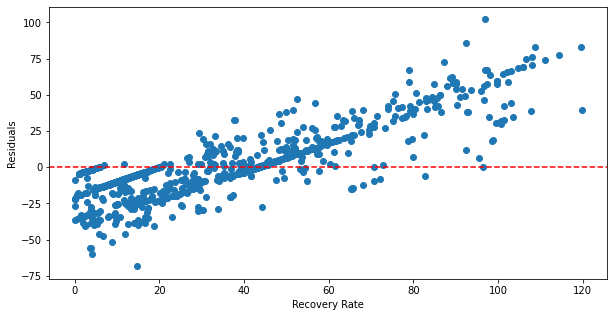

In [12]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()